A2: Maximizing accuracy under fairness constraints (C-SVM and C-LR)

Original paper, Fairness Constraints: Mechanisms for Fair Classification, can be found here: https://arxiv.org/pdf/1507.05259.pdf

This code, assuming necessary dependencies are installed, should run fully without the need to download any dataset (COMPAS) or change file paths. It also runs successfully on Google Colab as of April 2022 (Version 3). 

For timing, our group elected to run all notebooks on the same machine. This notebook should take approximately 10 seconds to run in Google Colab, and anywhere from 5-20 seconds locally depending on your processor.

In [1]:
import numpy as np
from random import seed, shuffle
from scipy.optimize import minimize # for loss func minimization
from collections import defaultdict
import matplotlib.pyplot as plt # for plotting stuff
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from copy import deepcopy

In [2]:
# Logistic regression prints lots of unfriendly warnings for the final notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
# for google colab
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/ADS_Proj4/compas-scores-two-years.csv')

# For local
#df = pd.read_csv('compas-scores-two-years.csv')

#universal 
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1523338610>]],
      dtype=object)

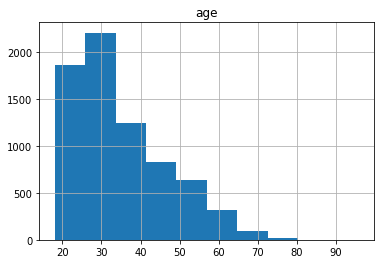

In [4]:
df.columns
df.hist(column = 'age')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f152323a590>]],
      dtype=object)

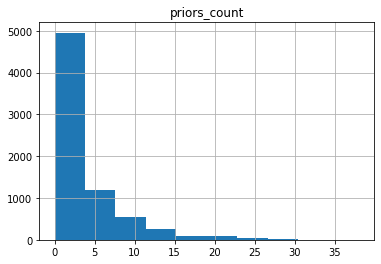

In [5]:
df.hist(column = 'priors_count')

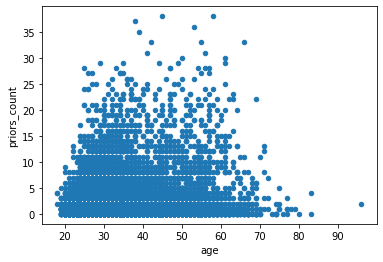

In [6]:
df.plot.scatter(x = 'age', y = 'priors_count')

In [7]:
#Preproccessing
features = ['race', 'age', 'sex', 'juv_misd_count', 'priors_count', 'juv_fel_count']
predictor = 'two_year_recid'
races = ['Caucasian', 'African-American']

df = df.loc[df['race'].isin(races), features + [predictor]]

# change to bools
df['sex'] = df['sex'].replace(['Male'],0)
df['sex'] = df['sex'].replace(['Female'],1)

df['race'] = df['race'].replace(['African-American'],0)
df['race'] = df['race'].replace(['Caucasian'],1)


#normalize 
normalized_df = (df-df.mean())/df.std()

df['age'] = normalized_df['age']
df['juv_fel_count'] = normalized_df['juv_fel_count']
df['juv_misd_count'] = normalized_df['juv_misd_count']
df['priors_count'] = normalized_df['priors_count']

#separate variables
X = df.drop('two_year_recid',axis=1)
Y = df['two_year_recid']


In [8]:
# model train code
def train_model(x, y, x_control, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma=None):
    assert((apply_accuracy_constraint == 1 and apply_fairness_constraints == 1) == False) # either accuracy or fairness
    #print("INSIDE TRAIN_MODEL")
    max_iter = 100000 # maximum number of iterations for the minimization algorithm

    # Add constraints, in our case fairness of race
    if apply_fairness_constraints == 0:
        constraints = []

    if apply_accuracy_constraint == 0: # just train normally
        f_args=(x, y)
        w = minimize(fun = loss_function,
            x0 = np.random.rand(x.shape[1],),
            args = f_args,
            method = 'SLSQP',
            options = {"maxiter":max_iter},
            constraints = constraints
            )

    else:
        # train on just the loss function
        w = minimize(fun = loss_function,
            x0 = np.random.rand(x.shape[1],),
            args = (x, y),
            method = 'SLSQP',
            options = {"maxiter":max_iter},
            constraints = []
            )

        old_w = deepcopy(w.x)
        #print("C!!!!!!!!!!!!!!!!!!!!!!! = ", constraints)
        

        def constraint_gamma_all(w, x, y,  initial_loss_arr):
            
            gamma_arr = np.ones_like(y) * gamma 
            new_loss = loss_function(w, x, y)
            old_loss = sum(initial_loss_arr)
            return ((1.0 + gamma) * old_loss) - new_loss

        constraints = []
        predicted_labels = np.sign(np.dot(w.x, x.T))
        unconstrained_loss_arr = loss_function(w.x, x, y, return_arr=True)
        #print("C!!!!!!!!!!!!!!!!!!!!!!! = ", constraints)

        c = ({'type': 'ineq', 'fun': constraint_gamma_all, 'args':(x,y,unconstrained_loss_arr)})
        constraints.append(c)


        def cross_cov_abs_optm_func(weight_vec, x_in, x_control_in_arr):
            cross_cov = (x_control_in_arr - np.mean(x_control_in_arr)) * np.dot(weight_vec, x_in.T)
            return float(abs(sum(cross_cov))) / float(x_in.shape[0])


        w = minimize(fun = cross_cov_abs_optm_func,
            x0 = old_w,
            args = (x, x_control[sensitive_attrs[0]]),
            method = 'SLSQP',
            options = {"maxiter":100000},
            constraints = constraints
            )

    return w.x


def _logistic_loss(w, X, y, return_arr=None):
	"""Computes the logistic loss.

  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
	"""
	yz = y * np.dot(X,w)

	if return_arr == True:
		out = -(log_logistic(yz))
	else:
		out = -np.sum(log_logistic(yz))
	return out


def log_logistic(X):
  ## http://fa.bianp.net/blog/2013/numerical-optimizers-for-logistic-regression/
  if X.ndim > 1: raise Exception("Array of samples cannot be more than 1-D!")
  out = np.empty_like(X) 
  idx = X>0
  out[idx] = -np.log(1.0 + np.exp(-X[idx]))
  out[~idx] = X[~idx] - np.log(1.0 + np.exp(X[~idx]))
  return out


In [9]:
#Logistic Regression

#From "Fairness Constraints: Mechanisms for Fair Classification"


#train/test split
train_size = 5000
x_train = df.loc[:train_size, features]
y_train = df.loc[:train_size, predictor]
x_test = df.loc[train_size:, features]
y_test = df.loc[train_size:, predictor]
x_control = {'race': x_train['race'].to_list()}

#base train, no constraints
apply_fairness_constraints = 0
apply_accuracy_constraint = 0
gamma = 0
sensitive_attrs = []
sensitive_attrs_to_cov_thresh = {}

#coefficients from training the model
train_plain = train_model(x_train.to_numpy(),
                y_train.to_numpy(),
                x_control,
                _logistic_loss,
                apply_fairness_constraints,
                apply_accuracy_constraint,
                sensitive_attrs,
                sensitive_attrs_to_cov_thresh,
                gamma)

print("Coeffs from training: ")
train_plain

Coeffs from training: 


array([ 1.90993132e+01, -1.40655032e+00,  1.77789945e+01, -1.13461746e-01,
        1.15905096e+00, -6.95941580e-03])

In [10]:
def compute_p_rule(x_control, class_labels):

    """ Compute the p-rule based on Doctrine of disparate impact """
    non_prot_all = sum(x_control == 1.0) # non-protected 
    prot_all = sum(x_control == 0.0) # protected group
    non_prot_pos = sum(class_labels[x_control == 1.0] == 1.0) # non_protected in positive class
    prot_pos = sum(class_labels[x_control == 0.0] == 1.0) # protected in positive class

    frac_non_prot_pos = float(non_prot_pos) / float(non_prot_all)
    frac_prot_pos = float(prot_pos) / float(prot_all)
    p_rule = (frac_prot_pos / frac_non_prot_pos) * 100.0

    print()
    print("n: %d" % (len(x_control)))
    print("# non-protected count: %d" % (non_prot_all))
    print("# protected count: %d" % (prot_all))
    print()
    print("number of non-protected in positive class: %d (%0.0f%%)" % (non_prot_pos, non_prot_pos * 100.0 / non_prot_all))
    print("number of protected in positive class: %d (%0.0f%%)" % (prot_pos, prot_pos * 100.0 / prot_all))
    print()
    print("P-rule is: %0.0f%%" % ( p_rule ))


    return p_rule


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

m = LogisticRegression()
m.coef_= train_plain.reshape((1,-1))
m.intercept_ = 0
m.classes_ = np.array([0, 1])
y_pred = m.predict(x_test[features])

print("Classification ")
print(classification_report(y_test, y_pred))
compute_p_rule(x_test['race'], y_pred)



Classification 
              precision    recall  f1-score   support

           0       0.68      0.19      0.29       992
           1       0.50      0.90      0.64       887

    accuracy                           0.52      1879
   macro avg       0.59      0.54      0.47      1879
weighted avg       0.59      0.52      0.46      1879


n: 1879
# non-protected count: 745
# protected count: 1134

number of non-protected in positive class: 745 (100%)
number of protected in positive class: 860 (76%)

P-rule is: 76%


75.83774250440916

In [12]:
output = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred
})

#print(output)

df_out = pd.merge(df,output,how = 'left',left_index = True, right_index = True)

df_out.dropna(inplace=True, subset=['y_test', 'y_pred'])
#print(df_out)

df_out_protected = df_out[df_out.race == 0]
#print(df_out_protected)

protected_correct = df_out_protected[df_out_protected.y_test == df_out_protected.y_pred]
#print(protected_correct)

protected_accuracy = len(df_out_protected[df_out_protected.y_test == df_out_protected.y_pred])/len(df_out_protected)
print("protected accuracy ", protected_accuracy)

df_out_nonprotected = df_out[df_out.race == 1]

nonprotected_accuracy = len(df_out_nonprotected[df_out_nonprotected.y_test == df_out_nonprotected.y_pred])/len(df_out_nonprotected)
print("non-protected accuracy ", nonprotected_accuracy)

calibration = abs(protected_accuracy - nonprotected_accuracy)
print("calibration ", calibration)
 



protected accuracy  0.6058201058201058
non-protected accuracy  0.4
calibration  0.2058201058201058


Calculate c, constraint covar which balances the trade off between fairness and accuracy

In [13]:
def constraints_covar(x_train, y_train, x_control_train, sensitive_attrs, sensitive_attrs_to_cov_thresh):

    #obtians list of constraints to be fed to the minimizer

    constraints = []

    for attr in sensitive_attrs:
        attr_arr = x_control_train[attr]
        attr_arr_transformed, index_dict = get_one_hot_encoding(attr_arr)
                
        if index_dict is None: # binary attribute
            thresh = sensitive_attrs_to_cov_thresh[attr]
            c = ({'type': 'ineq', 'fun': test_sensitive_attr_constraint_cov, 'args':(x_train, y_train, attr_arr_transformed,thresh, False)})
            constraints.append(c)
        else: # otherwise, its a categorical attribute, so we need to set the cov thresh for each value separately
            for attr_val, ind in index_dict.items():
                attr_name = attr_val                
                thresh = sensitive_attrs_to_cov_thresh[attr][attr_name]
                
                t = attr_arr_transformed[:,ind]
                c = ({'type': 'ineq', 'fun': test_sensitive_attr_constraint_cov, 'args':(x_train, y_train, t ,thresh, False)})
                constraints.append(c)

    return constraints

def test_sensitive_attr_constraint_cov(model, x_arr, y_arr_dist_boundary, x_control, thresh, verbose):
    assert(x_arr.shape[0] == x_control.shape[0])
    if len(x_control.shape) > 1: # check
        assert(x_control.shape[1] == 1)
    
    arr = []
    if model is None:
        arr = y_arr_dist_boundary # outputs
    else:
        arr = np.dot(model, x_arr.T) # the product with the weight vector -- the sign of this is the output label
    
    arr = np.array(arr, dtype=np.float64)

    cov = np.dot(x_control - np.mean(x_control), arr ) / float(len(x_control))
        
    ans = thresh - abs(cov) # will be <0 if the covariance is greater than thresh -- that is, the condition is not satisfied
    
    if verbose is True:
        print("Covariance is", cov)
        print("Diff is:", ans)
        print
    return ans


def get_one_hot_encoding(in_arr):
    for k in in_arr:
        if str(type(k)) != "<type 'numpy.float64'>" and type(k) != int and type(k) != np.int64:
            print(str(type(k)))
            print("************* ERROR: Input arr does not have integer types")
            return None
        
    in_arr = np.array(in_arr, dtype=int)
    assert(len(in_arr.shape)==1) # no column, means it was a 1-D arr
    attr_vals_uniq_sorted = sorted(list(set(in_arr)))
    num_uniq_vals = len(attr_vals_uniq_sorted)
    if (num_uniq_vals == 2) and (attr_vals_uniq_sorted[0] == 0 and attr_vals_uniq_sorted[1] == 1):
        return in_arr, None
    
    index_dict = {} # value to the column number
    for i in range(0,len(attr_vals_uniq_sorted)):
        val = attr_vals_uniq_sorted[i]
        index_dict[val] = i

    out_arr = []    
    for i in range(0,len(in_arr)):
        tup = np.zeros(num_uniq_vals)
        val = in_arr[i]
        ind = index_dict[val]
        tup[ind] = 1 # set that value of tuple to 1
        out_arr.append(tup)

    return np.array(out_arr), index_dict

In [14]:
def add_intercept(x):
    m,n = x.shape
    intercept = np.ones(m).reshape(m, 1) # the constant b
    return np.concatenate((intercept, x), axis = 1)

In [15]:
#SVM
# google colab
#df = pd.read_csv('/content/drive/MyDrive/ADS_Proj4/compas-scores-two-years.csv')

#local
#df = pd.read_csv('compas-scores-two-years.csv')

#universal 
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')


#Preproccessing
features = ['race', 'age', 'sex', 'juv_misd_count', 'priors_count', 'juv_fel_count']
predictor = 'two_year_recid'
races = ['Caucasian', 'African-American']

df = df.loc[df['race'].isin(races), features + [predictor]]

# change to bools
df['sex'] = df['sex'].replace(['Male'],0)
df['sex'] = df['sex'].replace(['Female'],1)

df['race'] = df['race'].replace(['African-American'],0)
df['race'] = df['race'].replace(['Caucasian'],1)


#normalize 
normalized_df = (df-df.mean())/df.std()
df['age'] = normalized_df['age']
df['juv_fel_count'] = normalized_df['juv_fel_count']
df['juv_misd_count'] = normalized_df['juv_misd_count']
df['priors_count'] = normalized_df['priors_count']

#separate variables
X = df.drop('two_year_recid',axis=1)
Y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

#Add Fairness Constraints and p% evaluation
compute_p_rule(X_test['race'], y_pred)



[[532  94]
 [370 234]]
              precision    recall  f1-score   support

           0       0.59      0.85      0.70       626
           1       0.71      0.39      0.50       604

    accuracy                           0.62      1230
   macro avg       0.65      0.62      0.60      1230
weighted avg       0.65      0.62      0.60      1230


n: 1230
# non-protected count: 474
# protected count: 756

number of non-protected in positive class: 77 (16%)
number of protected in positive class: 251 (33%)

P-rule is: 204%


204.38054009482585

In [16]:
output = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred
})

df_out = pd.merge(df,output,how = 'left',left_index = True, right_index = True)
df_out.dropna(inplace=True)
df_out_protected = df_out[df_out.race == 0]

#df_out_protected
#protected_correct = df_out_protected[df_out_protected.y_test == df_out_protected.y_pred]

protected_accuracy = len(df_out_protected[df_out_protected.y_test == df_out_protected.y_pred])/len(df_out_protected)
print("protected accuracy ", protected_accuracy)
 
df_out_nonprotected = df_out[df_out.race == 1]

nonprotected_accuracy = len(df_out_nonprotected[df_out_nonprotected.y_test == df_out_nonprotected.y_pred])/len(df_out_nonprotected)
print("non-protected accuracy ", nonprotected_accuracy)

calibration = abs(protected_accuracy - nonprotected_accuracy)
print("calibration ", calibration)



protected accuracy  0.6256613756613757
non-protected accuracy  0.6181434599156118
calibration  0.007517915745763881
